<a href="https://colab.research.google.com/github/uakarsh/latr/blob/main/examples/textvqa/LaTr_TextVQA_Part_3_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Downloading the requirements

!pip install -q transformers
!pip install -q sentencepiece==0.1.91
!pip install -q pytesseract
!sudo apt install -q tesseract-ocr
!pip install -q 'Pillow==7.1.2'
!pip install -q pytorch-lightning

     |████████████████████████████████| 4.4 MB 34.1 MB/s 
     |████████████████████████████████| 6.6 MB 57.4 MB/s 
     |████████████████████████████████| 596 kB 62.4 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 1.1 MB 15.1 MB/s 
     |████████████████████████████████| 3.1 MB 15.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr te

In [ ]:
!git clone https://github.com/uakarsh/latr.git
import sys
sys.path.append('/content/latr/src/latr/')

Cloning into 'latr'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 154 (delta 58), reused 85 (delta 23), pack-reused 0
Receiving objects: 100% (154/154), 675.47 KiB | 11.45 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Default Library import

import os
import json
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import json

## For the purpose of displaying the progress of map function
tqdm.pandas()

## Visualization libraries
from google.colab.patches import cv2_imshow
import pytesseract
from PIL import Image, ImageDraw

## Specific libraries of LaTr
import torch.nn as nn
from dataset import load_json_file, get_specific_file, resize_align_bbox, get_tokens_with_boxes, create_features
from modeling import LaTr_for_pretraining
from utils import convert_ans_to_token, convert_ques_to_token, rotate, convert_token_to_ques, convert_token_to_answer

## Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
## Setting the hyperparameters as well as primary configurations

PAD_TOKEN_BOX = [0, 0, 0, 0]
max_seq_len = 512
batch_size = 2
target_size = (500,384)
t5_model = "t5-base"

In [ ]:
## The TextVQA Dataset is present in my drive
## It can be downloaded from this link: https://drive.google.com/drive/folders/1bR03cRGnPENCiUaurKSGTSNQHUQlsDCR?usp=sharing or from official dataset 
##  and place it in the google drive, thats it!!

base_path = 'drive/MyDrive/TextVQA/'
train_ocr_json_path = os.path.join(base_path, 'TextVQA_Rosetta_OCR_v0.2_train.json')
train_json_path = os.path.join(base_path, 'TextVQA_0.5.1_train.json')

val_ocr_json_path = os.path.join(base_path, 'TextVQA_Rosetta_OCR_v0.2_val.json')
val_json_path = os.path.join(base_path, 'TextVQA_0.5.1_val.json')

In [ ]:
train_ocr_json = json.load(open(train_ocr_json_path))['data']
train_json = json.load(open(train_json_path))['data']

val_ocr_json = json.load(open(val_ocr_json_path))['data']
val_json = json.load(open(val_json_path))['data']

In [ ]:
## Useful for the key-value extraction

train_json_df = pd.DataFrame(train_json)
train_ocr_json_df = pd.DataFrame(train_ocr_json)

val_json_df = pd.DataFrame(val_json)
val_ocr_json_df = pd.DataFrame(val_ocr_json)

In [ ]:
## Converting list to string

train_json_df['answers'] = train_json_df['answers'].apply(lambda x: " ".join(list(map(str, x))))
val_json_df['answers']   = val_json_df['answers'].apply(lambda x: " ".join(list(map(str, x))))

In [ ]:
## Dropping of the images which doesn't exist, might take some time

base_img_path = os.path.join('drive/MyDrive/TextVQA', 'train_images')
train_json_df['path_exists'] = train_json_df['image_id'].progress_apply(lambda x: os.path.exists(os.path.join(base_img_path, x)+'.jpg'))
train_json_df = train_json_df[train_json_df['path_exists']==True]

val_json_df['path_exists'] = val_json_df['image_id'].progress_apply(lambda x: os.path.exists(os.path.join(base_img_path, x)+'.jpg'))
val_json_df = val_json_df[val_json_df['path_exists']==True]

  0%|          | 0/34602 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
train_json_df.drop(columns = ['flickr_original_url', 'flickr_300k_url','image_classes', 'question_tokens', 'path_exists'
                              ], axis = 1, inplace = True)
val_json_df.drop(columns = ['flickr_original_url', 'flickr_300k_url','image_classes', 'question_tokens', 'path_exists'
                              ], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
## Deleting the json

del train_json
del train_ocr_json
del val_json
del val_ocr_json

In [ ]:
## Grouping for the purpose of feature extraction
grouped_df = train_json_df.groupby('image_id')

## Getting all the unique keys of the group by object
keys = list(grouped_df.groups.keys())

In [ ]:
label2id = {}   ## Would be responsible for mapping answer to token
raw_answer = train_json_df['answers'].values.tolist()

In [ ]:
current_word_id = 1   ## Not zero, because T5 tokenizer has a pad_token_id = 0, and we would keep pad token id to be 0 for padding the answer

for ans in tqdm(raw_answer):
  for word in ans.split(" "):

    if word not in label2id:
      label2id[word] = {'id':current_word_id, 'count': 1}
      current_word_id+=1
      
    else:
      label2id[word]['count']+=1

  0%|          | 0/27068 [00:00<?, ?it/s]

In [ ]:
## Adding the validation answer tokens as well

raw_answer = val_json_df['answers'].values.tolist()
for ans in tqdm(raw_answer):
  for word in ans.split(" "):

    if word not in label2id:
      label2id[word] = {'id':current_word_id, 'count': 1}
      current_word_id+=1
      
    else:
      label2id[word]['count']+=1

  0%|          | 0/3892 [00:00<?, ?it/s]

In [ ]:
id2label = ["" for _ in range(current_word_id)]
for key, value in list(label2id.items()):
  id2label[value['id']] = key

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained(t5_model)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


## Making the Dataset

In [ ]:
## Defining the pytorch dataset

from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms

class TextVQA(Dataset):
  def __init__(self, base_img_path, json_df, ocr_json_df, tokenizer ,label2id, transform = None, max_seq_length = 512, target_size = (500,384)):

    self.base_img_path = base_img_path
    self.json_df = json_df
    self.ocr_json_df = ocr_json_df
    self.tokenizer = tokenizer
    self.target_size = target_size
    self.transform = transform
    self.max_seq_length = max_seq_length
    self.label2id = label2id

  def __len__(self):
    return len(self.json_df)

  def __getitem__(self, idx):

    curr_img = self.json_df.iloc[idx]['image_id']
    ocr_token = self.ocr_json_df[self.ocr_json_df['image_id']==curr_img]['ocr_info'].values.tolist()[0]

    boxes = []
    words = []

    current_group = self.json_df.iloc[idx]
    width, height = current_group['image_width'], current_group['image_height']

    ## Getting the ocr and the corresponding bounding boxes
    for entry in ocr_token:
      xmin, ymin, w, h, angle = entry['bounding_box']['top_left_x'], entry['bounding_box']['top_left_y'],  entry['bounding_box']['width'],  entry['bounding_box']['height'], entry['bounding_box']['rotation']
      xmin, ymin,w, h = resize_align_bbox([xmin, ymin, w, h], 1, 1, width, height)

      x_centre = xmin + (w/2)
      y_centre = ymin + (h/2)

      # print("The angle is:", angle)
      xmin, ymin = rotate([x_centre, y_centre], [xmin, ymin], angle)

      xmax = xmin + w
      ymax = ymin + h

      ## Bounding boxes are normalized
      curr_bbox = [xmin, ymin, xmax, ymax]
      boxes.append(curr_bbox)
      words.append(entry['word'])

    img_path = os.path.join(self.base_img_path, curr_img)+'.jpg'  ## Adding .jpg at end of the image, as the grouped key does not have the extension format 

    assert os.path.exists(img_path)==True, f'Make sure that the image exists at {img_path}!!'
    ## Extracting the feature
    img, boxes, tokenized_words = create_features(image_path = img_path,
                                                  tokenizer = self.tokenizer,
                                                  target_size = self.target_size,
                                                  max_seq_length = self.max_seq_length,
                                                  use_ocr = False,
                                                  bounding_box = boxes,
                                                  words = words
                                                  )
    
    ## Converting the boxes as per the format required for model input
    boxes = torch.as_tensor(boxes, dtype=torch.int32)
    width = (boxes[:, 2] - boxes[:, 0]).view(-1, 1)
    height = (boxes[:, 3] - boxes[:, 1]).view(-1, 1)
    boxes = torch.cat([boxes, width, height], axis = -1)

    ## Tensor tokenized words
    tokenized_words = torch.as_tensor(tokenized_words, dtype=torch.int32)

    if self.transform is not None:
      img = self.transform(img)
    else:
      img = transforms.ToTensor()(img)


    ## Getting the Question
    question = current_group['question']   
    question = convert_ques_to_token(question = question, tokenizer = self.tokenizer)

    ## Getting the Answer
    answer = current_group['answers']
    answer = convert_ans_to_token(answer, self.label2id).long()

    return {'img':img, 'boxes': boxes, 'tokenized_words': tokenized_words, 'question': question, 'answer': answer}

In [ ]:
train_ds = TextVQA(base_img_path = base_img_path,
                   json_df = train_json_df,
                   ocr_json_df = train_ocr_json_df,
                   tokenizer = tokenizer,
                   label2id = label2id,
                   transform = None, 
                   max_seq_length = max_seq_len, 
                   target_size = target_size
                   )


val_ds = TextVQA(base_img_path = base_img_path,
                   json_df = val_json_df,
                   ocr_json_df = val_ocr_json_df,
                   tokenizer = tokenizer,
                   label2id = label2id,
                   transform = None, 
                   max_seq_length = max_seq_len, 
                   target_size = target_size
                   )

In [ ]:
idx = 2

In [ ]:
encoding = val_ds[idx]  ## Might take time as per the processing

In [ ]:
for key in list(encoding.keys()):
  print_statement = '{0: <30}'.format(str(key) + " has a shape:")
  print(print_statement, encoding[key].shape)

img has a shape:               torch.Size([3, 384, 500])
boxes has a shape:             torch.Size([512, 6])
tokenized_words has a shape:   torch.Size([512])
question has a shape:          torch.Size([512])
answer has a shape:            torch.Size([512])


In [ ]:
## Sample Img, Sample box, sample words, sample answer, sample question

s_img = encoding['img']
s_boxes = encoding['boxes']
s_words = encoding['tokenized_words']
s_ans = encoding['answer']
s_ques = encoding['question']

## Decoding the Question, Answer as well as the Image for the post-processing

### 1. Image Part

In [ ]:
## OCR and Image part
actual_img = transforms.ToPILImage()(s_img).convert("RGB")
actual_boxes = s_boxes[:, :4].numpy().tolist()  ## (xmin, ymin, xmax, ymax)

In [ ]:
from PIL import Image, ImageDraw

# create rectangle image
draw_on_img = ImageDraw.Draw(actual_img)  

for box in actual_boxes:
  draw_on_img.rectangle(box, outline ="red")


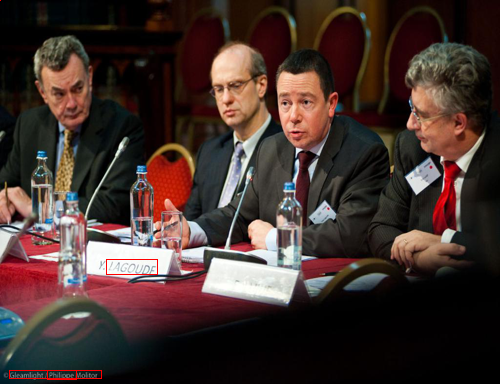

In [ ]:
actual_img

### 2. Question Part

In [ ]:
decoded_ques = convert_token_to_ques(s_ques, tokenizer)
print(decoded_ques)  ## Goes well!!

who was the photographer?


### 3. Answer Part

In [ ]:
decoded_answer = convert_token_to_answer(s_ans, id2label)
print(decoded_answer)  ## Goes Well!!

philippe molitor philippe molitor philippe molitor philippe molitor clardajne phillipe molida l no phillipe meltow philippe molitar


## Making the DataLoader

In [ ]:
from transformers import ViTFeatureExtractor, ViTModel
vit_feat_extract = ViTFeatureExtractor("google/vit-base-patch16-224-in21k")

In [ ]:
def collate_fn(data_bunch):

  '''
  A function for the dataloader to return a batch dict of given keys

  data_bunch: List of dictionary
  '''

  dict_data_bunch = {}

  for i in data_bunch:
    for (key, value) in i.items():
      if key not in dict_data_bunch:
        dict_data_bunch[key] = []
      dict_data_bunch[key].append(value)

  for key in list(dict_data_bunch.keys()):
      dict_data_bunch[key] = torch.stack(dict_data_bunch[key], axis = 0)

  if 'img' in dict_data_bunch:
    ## Pre-processing for ViT
    dict_data_bunch['img'] = vit_feat_extract(list(dict_data_bunch['img']),return_tensors = 'pt')['pixel_values']

  return dict_data_bunch

In [ ]:
import pytorch_lightning as pl

class DataModule(pl.LightningDataModule):

  def __init__(self, train_dataset, val_dataset,  batch_size = 2):

    super(DataModule, self).__init__()
    self.train_dataset = train_dataset
    self.val_dataset = val_dataset
    self.batch_size = batch_size

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size, 
                      collate_fn = collate_fn, shuffle = True)
  
  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size,
                                  collate_fn = collate_fn, shuffle = False)

## Modeling

In [ ]:
## keys are img, boxes, tokenized_words, answer, question

In [ ]:
config = {
    't5_model': 't5-base',
    'vocab_size': 32128,
    'hidden_state': 768,
    'max_2d_position_embeddings': 1001,
    'classes': current_word_id,
    'seq_len': 512
}

In [ ]:
class LaTr_for_finetuning(nn.Module):
  def __init__(self, config, address_to_pre_trained_weights = None):
    super(LaTr_for_finetuning, self).__init__()

    self.config = config
    self.vocab_size = config['vocab_size']
    self.question_emb = nn.Embedding(config['vocab_size'], config['hidden_state'])

    self.pre_training_model = LaTr_for_pretraining(config)

    if address_to_pre_trained_weights is not None:
      self.pre_training_model.load_state_dict(torch.load(address_to_pre_trained_weights))
    self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
  
    ## In the fine-tuning stage of vit, except the last layer, all the layers were freezed

    self.classification_head = nn.Linear(config['hidden_state'], config['classes'])

  def forward(self, lang_vect, spatial_vect, quest_vect, img_vect):

    ## The below block of code calculates the language and spatial featuer
    embeded_feature =     self.pre_training_model.language_emb(lang_vect)
    top_left_x_feat =     self.pre_training_model.top_left_x(spatial_vect[:,:, 0])
    top_left_y_feat =     self.pre_training_model.top_left_y(spatial_vect[:,:, 1])
    bottom_right_x_feat = self.pre_training_model.bottom_right_x(spatial_vect[:,:, 2])
    bottom_right_y_feat = self.pre_training_model.bottom_right_y(spatial_vect[:,:, 3])
    width_feat =          self.pre_training_model.width_emb(spatial_vect[:,:, 4])
    height_feat =         self.pre_training_model.height_emb(spatial_vect[:,:, 5])

    spatial_lang_feat = embeded_feature + top_left_x_feat + top_left_y_feat + bottom_right_x_feat + bottom_right_y_feat + width_feat + height_feat

    ## Extracting the image feature, using the Vision Transformer
    img_feat = self.vit(img_vect).last_hidden_state
    
    ## Extracting the question vector
    quest_feat = self.question_emb(quest_vect)

    ## Concating the three features, and then passing it through the T5 Transformer
    final_feat = torch.cat([img_feat, spatial_lang_feat,quest_feat ], axis = -2)

    ## Passing through the T5 Transformer
    for layer in self.pre_training_model.list_encoder:
        final_feat = layer(final_feat)[0]

    final_feat = self.pre_training_model.residue_encoder(final_feat)

    for layer in self.pre_training_model.list_decoder:
        final_feat = layer(final_feat)[0]
    final_feat = self.pre_training_model.residue_decoder(final_feat)

    answer_vector = self.classification_head(final_feat)[:, :self.config['seq_len'], :]

    return answer_vector

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
finetuned_latr = LaTr_for_finetuning(config).to(device)

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

In [ ]:
datamodule = DataModule(train_ds, val_ds)

In [ ]:
sample_batch = next(iter(datamodule.train_dataloader()))

In [ ]:
answers = sample_batch['answer'].to(device)
boxes =   sample_batch['boxes'].to(device)
img =     sample_batch['img'].to(device)
question = sample_batch['question'].to(device)
words =   sample_batch['tokenized_words'].to(device)

In [ ]:
answer_vector = finetuned_latr(lang_vect = words, 
                               spatial_vect = boxes, 
                               img_vect = img, 
                               quest_vect = question
                               )

In [ ]:
loss = nn.CrossEntropyLoss()(answer_vector.reshape(-1,config['classes']), answers.reshape(-1))

In [ ]:
loss

tensor(10.2508, device='cuda:0', grad_fn=<NllLossBackward0>)